In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from Scrapping import ChromeManager, BeautifulSoupScrap as BSC
from Twitter import TwitterScrapper
from datetime import datetime, timedelta
import time
import json

In [2]:
corona_ratio_data = '..\\corona_lb_ratios.csv'

pd.set_option('display.max_rows', 255)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
df = pd.read_csv(corona_ratio_data, header=0)
df.head()

,date,year,month,day,new_cases,new_deaths,prev_cases,prev_deaths,total_cases,total_deaths,month_avg_ratio,cumulative_avg_ratio,diff_avg_ratio,simple_ratio
0,2/1/2020,2020,2,1,0,0,0,0,0,0,-1.0,-1.0,0.226023,-0.061092
1,2/2/2020,2020,2,2,0,0,0,0,0,0,-1.0,-1.0,0.226023,-0.061092
2,2/3/2020,2020,2,3,0,0,0,0,0,0,-1.0,-1.0,0.226023,-0.061092
3,2/4/2020,2020,2,4,0,0,0,0,0,0,-1.0,-1.0,0.226023,-0.061092
4,2/5/2020,2020,2,5,0,0,0,0,0,0,-1.0,-1.0,0.226023,-0.061092


In [6]:
x = df.month.map(str) + '_' + df.day.map(str)
y = df.diff_avg_ratio

zero = [0 for _ in range(len(x))]

max_value = df.diff_avg_ratio.max()
maximum = [max_value for _ in range(len(x))]

min_value = df.diff_avg_ratio.min()
minimum = [min_value for _ in range(len(x))]

std_value = df.diff_avg_ratio.std()
pos_std = [std_value for _ in range(len(x))]
neg_std = [-std_value for _ in range(len(x))]

In [8]:
hotspots_data = []
hotspots = []

for index, row in df.iterrows():
    # i choose to get the negative hotspots only for now
    # for positive & negative hotspots: (row.diff_avg_ratio >= std_value() or (row.diff_avg_ratio <= -std_value)
    if row.diff_avg_ratio <= -std_value:
        hotspots_data.append(row.date)
        hotspots.append(row.diff_avg_ratio)
        
    else:
        hotspots.append(0)
        
    
print(len(hotspots_data), 'negative hotspots')
print(len(hotspots), '_spots')

12 negative hotspots
232 spots


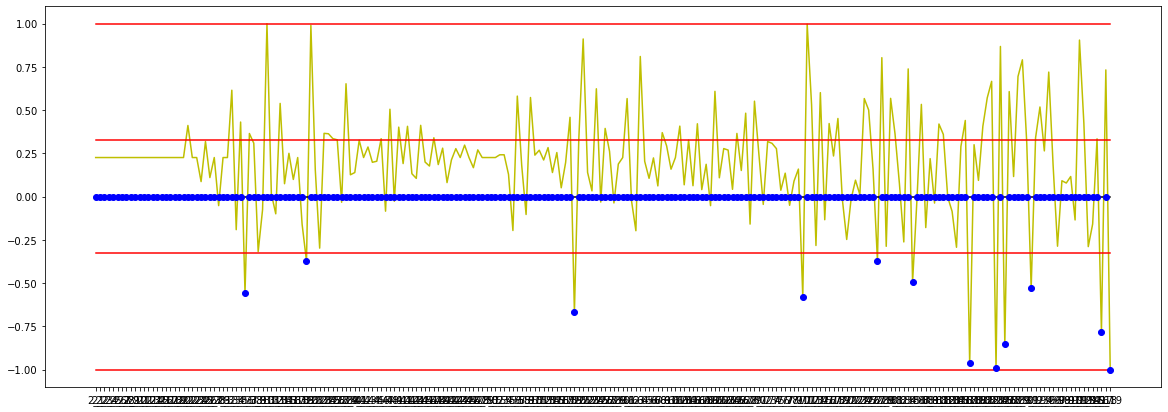

In [9]:
plt.figure(figsize=(20, 7))
plt.plot(
    x, y, 'y', 
    x, zero, 'black',
    x, maximum, 'r', 
    x, minimum, 'r', 
    x, pos_std, 'r',
    x, neg_std, 'r',
    x, hotspots, 'bo'
)

In [15]:
def get_trends(dates):
    final_trends = set()
    for date in dates:
        trends = BSC.get_elements(
            "div.col-lg-8 > div > ul > li > a",
            source=f'https://trendogate.com/placebydate/23424873/{date}',
            attributes=True
        )
        for trend in trends:
            if trend:
                final_trends.add(trend['text'])

        time.sleep(0.5)

    return list(final_trends)

#----------------------------------------------------------------------------------------------------

def get_date_range(date):
    date = datetime.strptime(date, '%m/%d/%Y')
    day_before = date - timedelta(days=1)
    return [
        day_before.strftime('%Y-%m-%d'),
        date.strftime('%Y-%m-%d')
    ]

#----------------------------------------------------------------------------------------------------

hotspots_topics_trends = {}

def get_hotspot_topics(date):
    global hotspots_topics_trends

    dates = get_date_range(date)
    trends = get_trends(dates)

    hotspots_topics_trends[f'{date}'] = trends

    print('[Date]:', date)
    print('[Trends]:', trends)
    print('------------------------------------------')

#----------------------------------------------------------------------------------------------------
    
def get_hotspots_topics(hotspots):
    for hotspot in hotspots:
        get_hotspot_topics(hotspot)

    with open('hotspots_topics_trends.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(hotspots_topics_trends, indent=2, ensure_ascii=False))
    
    print('Done!!')

In [16]:
get_hotspots_topics(hotspots_data)

[Date]: 3/4/2020
[Trends]: [' dubai', ' #يسقط_القاضي_غسان_عويدات', ' #برشلونه', ' #صيدا', ' #Egypt', ' #حسان_دياب', ' #كورونا_في_لبنان', ' #المصارف', ' الاطارات المشتعله', ' فتح السير', ' #mufc', ' #IWD2020', ' #خامنيي', ' #lbcilebanon', ' #russia', ' اليكم التفاصيل', ' #covid_19', ' #شهداونا_عظماونا', ' Greece', ' Biden', ' #الاسد', ' #للفساد_زعيم_يحميه', ' warren', ' #lebanonprotests', ' muslim', ' #صار_الوقت', ' #iwd2020', ' حسان دياب', ' #HalaMadrid', ' #حكومه_بصلاحيات_استثناييه', ' egypt', ' #دياب', ' الجيش السوري', ' #photography', ' الشهيد القايد', ' التحكم المروري', ' #انتخابات_نيابيه_مبكره', ' QUEEN', ' #engl256b', ' مجلس الوزراء', ' #coronaoutbreak', ' whatsapp', ' #breaking', ' #Coronvirus', ' #بوتين', ' علي ابراهيم', ' #لبنان__ينتفض', ' #العوده', ' #الشعب_اللبناني_الفقير', ' #neverwornwhite', ' #انا_ثاير_مش_بلطجي', ' الحجر الصحي', ' #ترامب', ' GIRL', ' #coronaalert', ' #فرنسا', ' #gaming', ' biden', ' #bestmusicvideo', ' #ثوره', ' #شو_هالزمن', ' european', ' Send', ' #Syria